In [7]:
# #Import necessary libraries
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Activation
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
import json

### Load the MNIST Dataset

In [8]:
# Load MNIST dataset into train and test

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

print(len(train_images)) # len(train_labels) = 60000
print(len(test_images))  # len(test_labels) = 10000

60000
10000


### Lets look at the frequency of each digit in the dataset

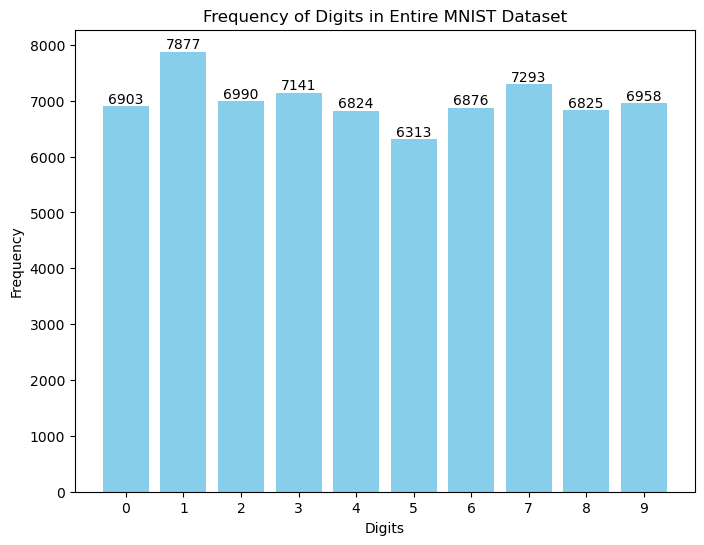

In [9]:
# Combine labels from both training and test sets
combined_labels = np.concatenate((train_labels, test_labels))

# Count occurrences of each digit in combined labels
digit_counts = np.bincount(combined_labels)

# Plot histogram for entire dataset
plt.figure(figsize=(8, 6))
bars = plt.bar(np.arange(10), digit_counts, color='skyblue')
plt.xticks(np.arange(10), [str(i) for i in range(10)])
plt.xlabel('Digits')
plt.ylabel('Frequency')
plt.title('Frequency of Digits in Entire MNIST Dataset')

# Annotate values on top of each bar
for bar, count in zip(bars, digit_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count), ha='center', va='bottom')

plt.show()

### Visualize the MNIST Dataset

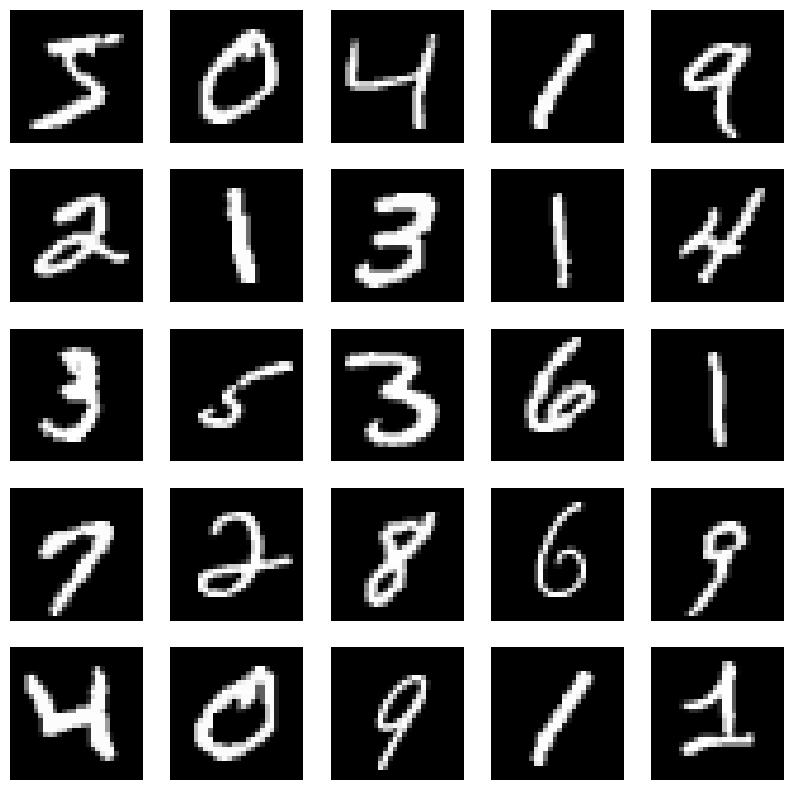

In [10]:
# Lets visualize this MNIST dataset 
plt.figure(figsize=(10, 10))
for i in range(25):
    
    plt.subplot(5, 5, i + 1)  # .subplot creates a subplot within the grid 
    # 5 rows, 5 cols, i is index of current subplot which starts from 0 as per for loop
    
    plt.imshow(train_images[i], cmap='gray')  #  This displays the image at index i from the train_images array 
    # The MNIST dataset consists of grayscale images. Using the grayscale colormap is a common choice because 
    # it accurately represents these images, ( other cmap choices are 'viridis', 'jet' etc)
    
    plt.axis('off') # turn off the gridlines on x and y axes of each image in subplots

plt.show()

### Split the training data

In [11]:
# Splitting the training data into actual training and validation sets while keeping test data intact 
# X_train, x_test, y_train, y_test = train_test_split(...)
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

# After executing the above line of code, the variables train_images and train_labels will hold the reduced training data 
#(80% of the original training data), while newly formed variables called val_images and val_labels will contain the validation data 
#(20% of the original training data) that the model will use to evaluate its performance during training phase

In [12]:
print(len(train_images))
print(len(test_images))

48000
10000


### Define the neural network

In [13]:
# Define the model architecture
model = Sequential([
    Conv2D(filters=32, kernel_size=5, strides=1, activation='relu', input_shape=(28, 28, 1), kernel_regularizer=l2(0.0005)),
    Conv2D(filters=32, kernel_size=5, strides=1, use_bias=False),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(pool_size=2, strides=2),
    Dropout(0.25),
    Conv2D(filters=64, kernel_size=3, strides=1, activation='relu', kernel_regularizer=l2(0.0005)),
    Conv2D(filters=64, kernel_size=3, strides=1, use_bias=False),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(pool_size=2, strides=2),
    Dropout(0.25),
    Flatten(),
    Dense(units=256, use_bias=False),
    BatchNormalization(),
    Activation("relu"),
    Dense(units=128, use_bias=False),
    BatchNormalization(),
    Activation("relu"),
    Dense(units=84, use_bias=False),
    BatchNormalization(),
    Activation("relu"),
    Dropout(0.25),
    Dense(units=10, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### standardize the input data and train the model

In [14]:
# Calculate mean and standard deviation for the training set for standardization of data
mean_px = train_images.mean().astype(np.float32)
std_px = train_images.std().astype(np.float32)

# Standardize the data ( make the mean 0 and std dev 1 for every input data point)
train_images = (train_images - mean_px) / std_px
val_images = (val_images - mean_px) / std_px
test_images = (test_images - mean_px) / std_px


# Train the model 
# history = model.fit(train_images, train_labels, epochs=50, validation_data=(val_images, val_labels))

In [15]:
# print(train_images.shape)
# print(mean_px)
# print(std_px)

In [16]:
# After training the model...

# Save the model to a file
# model.save('mnist_cnn_50epochs_latest.h5')  # this only saves the weights not the model train-val accuracy-loss history for each epoch

# Print a confirmation message
# print("Model saved successfully!")


In [17]:
# load model from saved h5 file

# model = load_model("mnist_models/mnist_cnn_50epochs_latest.h5")  # Replace with your model path
# print("model loaded successfully")



model loaded successfully


In [18]:
# history

### model metrics

In [19]:
# Evaluate model on test data
test_loss, test_accuracy = model.evaluate(test_images, test_labels)

print(f"Test accuracy: {test_accuracy * 100:.2f}%")



313/313 [==============================] - 7s 18ms/step - loss: 0.0297 - accuracy: 0.9939
Test accuracy: 99.39%


In [20]:
#  # Evaluate model on validation data
val_loss, val_accuracy = model.evaluate(val_images, val_labels)

print(f"Validation accuracy: {val_accuracy * 100:.2f}%")


375/375 [==============================] - 7s 18ms/step - loss: 0.0363 - accuracy: 0.9932
Validation accuracy: 99.32%


In [21]:
# Predictions on test data
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

313/313 [==============================] - 6s 17ms/step


In [22]:
# Find misclassified indices
misclassified_indices = np.where(predicted_labels != test_labels)[0]
print(len(misclassified_indices),"images out of 10000 in test set were not predicted correctly, below is the breakdown\n")

# Count misclassifications for each digit 963
misclassified_counts = {digit: 0 for digit in range(10)}  # Initialize counts for digits 0-9

for index in misclassified_indices:
    actual_label = test_labels[index]
    predicted_label = predicted_labels[index]
    if actual_label != predicted_label:
        misclassified_counts[actual_label] += 1

# Display the counts
for digit, count in misclassified_counts.items():
    print(f"Digit {digit} misclassified {count} times.")

61 images out of 10000 in test set were not predicted correctly, below is the breakdown

Digit 0 misclassified 4 times.
Digit 1 misclassified 2 times.
Digit 2 misclassified 7 times.
Digit 3 misclassified 4 times.
Digit 4 misclassified 5 times.
Digit 5 misclassified 6 times.
Digit 6 misclassified 10 times.
Digit 7 misclassified 5 times.
Digit 8 misclassified 6 times.
Digit 9 misclassified 12 times.


In [23]:
# Create a dictionary to store misclassification details
misclassified_details = {digit: {misclassified_digit: 0 for misclassified_digit in range(10)} for digit in range(10)}

# Iterate through misclassified indices and store details
for index in misclassified_indices:
    actual_label = test_labels[index]
    predicted_label = predicted_labels[index]
    if actual_label != predicted_label:
        misclassified_details[actual_label][predicted_label] += 1
        

# Display misclassification details
for digit, details in misclassified_details.items():
    print(f"Misclassifications for Digit {digit}:\n")
    for misclassified_digit, count in details.items():
        if count > 0:
            print(f"  Misclassified as {misclassified_digit}: {count} times")

    print("_"*100)

Misclassifications for Digit 0:

  Misclassified as 1: 1 times
  Misclassified as 5: 1 times
  Misclassified as 6: 1 times
  Misclassified as 7: 1 times
____________________________________________________________________________________________________
Misclassifications for Digit 1:

  Misclassified as 7: 2 times
____________________________________________________________________________________________________
Misclassifications for Digit 2:

  Misclassified as 0: 1 times
  Misclassified as 3: 1 times
  Misclassified as 7: 5 times
____________________________________________________________________________________________________
Misclassifications for Digit 3:

  Misclassified as 2: 1 times
  Misclassified as 5: 2 times
  Misclassified as 9: 1 times
____________________________________________________________________________________________________
Misclassifications for Digit 4:

  Misclassified as 2: 1 times
  Misclassified as 6: 1 times
  Misclassified as 9: 3 times
___________

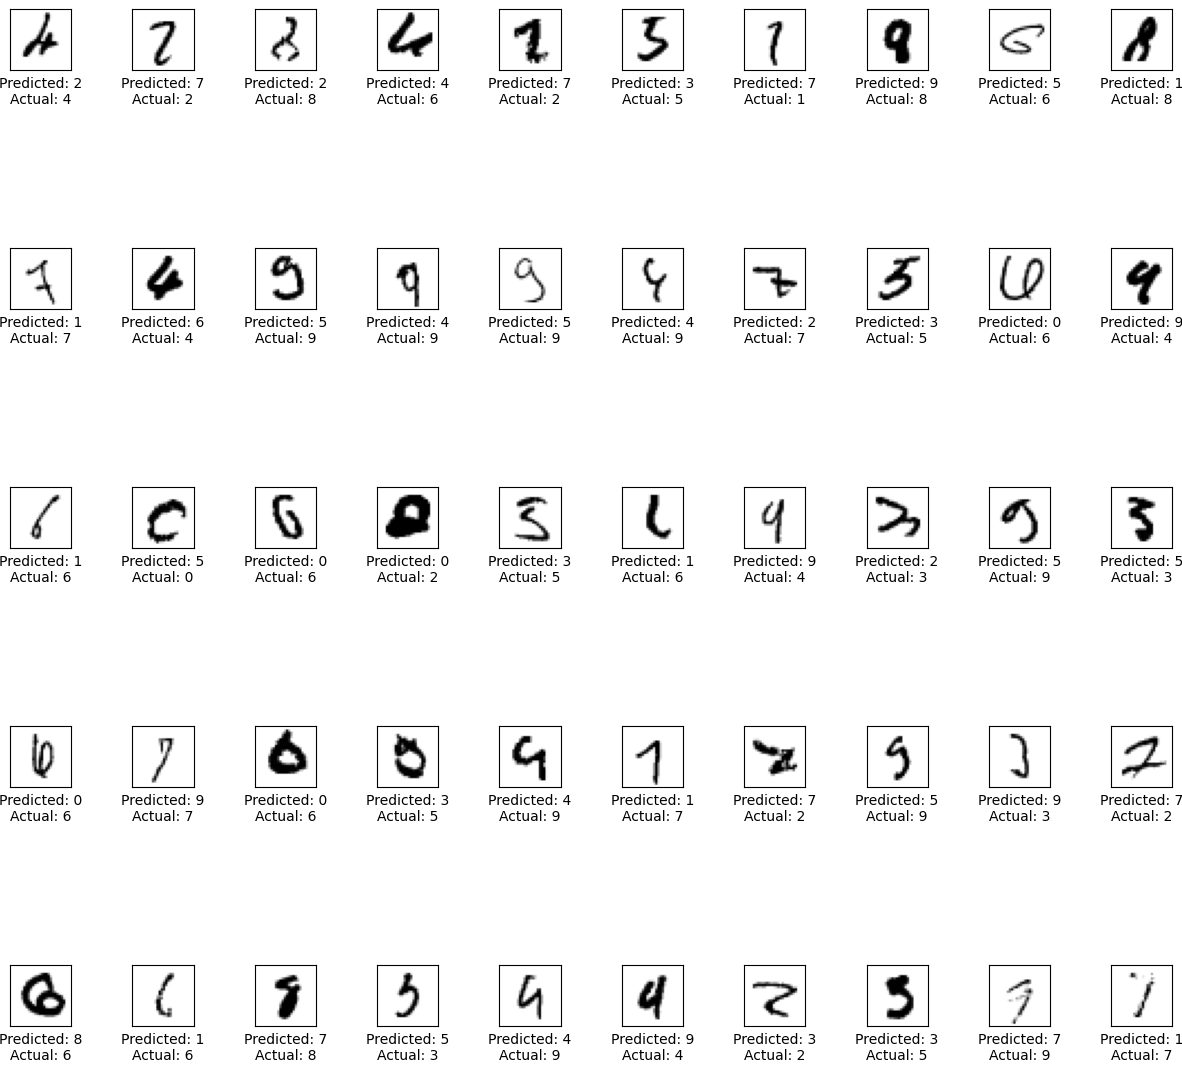

In [24]:
# Visualize these misclassified images
plt.figure(figsize=(15, 15))

# plt.subplots_adjust(hspace=1.0)  # Increase vertical spacing between subplots, i fyou dont do this you wont be able to see the
# actual label which is just below the predicted label which is just below the image

plt.subplots_adjust(wspace=1.0)

for i, index in enumerate(misclassified_indices[:50]):  # Visualize the first 50 misclassified images
    plt.subplot(5, 10, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[index], cmap=plt.cm.binary)
    plt.xlabel(f"Predicted: {predicted_labels[index]}\nActual: {test_labels[index]}")
plt.show()